# 1 - Introduksjon og case

Espen Sirnes  
2024-09-18

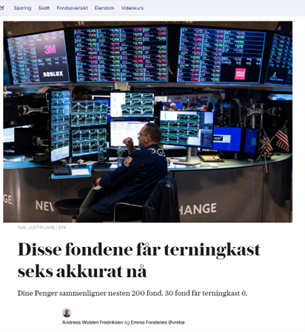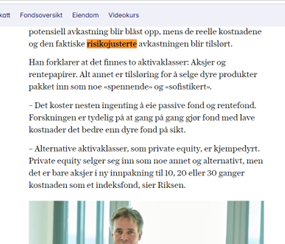

# Introduksjon

## Caset

-   Skriv en rapport om en aksje, fond eller strategi på TITLON, og
    argumenter for hvorfor dette er et bra, dårlig eller usikkert
    investeringscase.
-   I rapporten skal du bruke:
    -   Teori om forventning, nytte og risiko
    -   Porteføljeteori
    -   Faktorer
    -   Value At Risk

Det første dere begynner med, er å finne caset deres. Det trengs det
ingen forkunskap til

Det er veldig lurt å jobbe med temaet som vi har gått gjennom på
forelesning, etter gjeldende forelesning.

## I denne forelesningen

Korte om kursets tema: \* Forelesning 2: Forventning, nytte og risiko \*
Forelesning 3: Porteføljeteori og matriser \* Forelesning 4: Faktorer \*
Forelesning 5: Value at Risk (VaR)

# Forelesning 2: Forventning, nytte og risiko

Nyttefunksjonen:

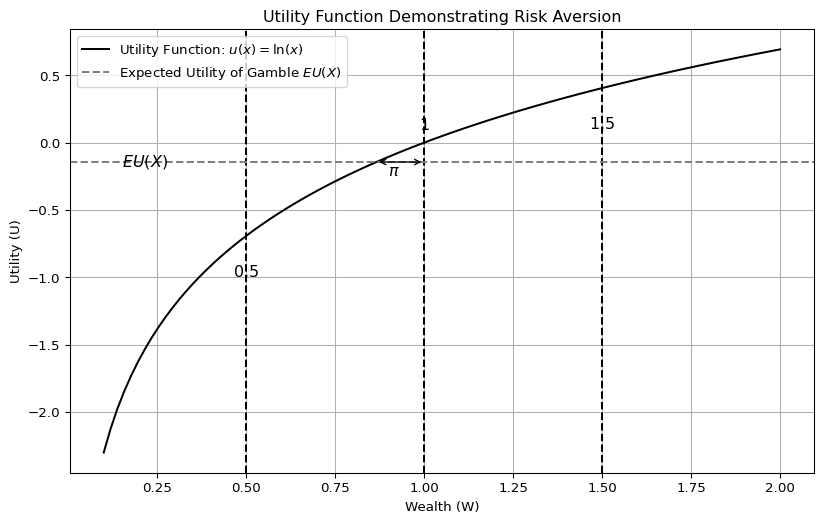

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Logarithmic utility function
def u_func(x):
    return np.log(x)

def x_func(u):
    return np.exp(u)

# Values for wealth and utility
x_vals = np.linspace(0.1, 2, 100)
u_x = u_func(x_vals)

# Gamble outcomes
x_gamble = [0.5, 1.5]  # Outcomes of the gamble
p_gamble = [0.5, 0.5]  # Probabilities

# Certain outcome
x_certain = 1

# Expected utility of the gamble
expected_utility = np.sum(np.array(p_gamble) * u_func(np.array(x_gamble)))

# Plotting the utility function
plt.figure(figsize=(10, 6))
plt.plot(x_vals, u_x, label=r'Utility Function: $u(x) = \ln(x)$', color='black')

# Plotting the certain outcome
plt.axvline(x=x_certain, color='black', linestyle='--')
plt.text(x_certain, u_func(x_certain) + 0.1, "$1$", horizontalalignment='center', fontsize=12)

# Plotting the gamble outcomes
plt.axvline(x=x_gamble[0], color='black', linestyle='--')
plt.axvline(x=x_gamble[1], color='black', linestyle='--')
plt.text(x_gamble[0], u_func(x_gamble[0]) - 0.3, "$0.5$", horizontalalignment='center', fontsize=12)
plt.text(x_gamble[1], u_func(x_gamble[1]) - 0.3, "$1.5$", horizontalalignment='center', fontsize=12)

# Plotting the expected utility
plt.axhline(y=expected_utility, color='gray', linestyle='--', label='Expected Utility of Gamble $EU(X)$')
plt.text(0.15, expected_utility, '$EU(X)$', verticalalignment='center', fontsize=12)

# Risk premium - distance between expected utility and utility of certain outcome
risk_premium = u_func(x_certain) - expected_utility
certainty_equivalence = x_func(expected_utility)
plt.annotate('', xy=(1, expected_utility), xytext=(certainty_equivalence, expected_utility),
             arrowprops=dict(facecolor='black', arrowstyle='<->'))
# Separate annotation for the label (π) without the arrow
plt.annotate(r'$\pi$', xy=(0.9, expected_utility -0.1), fontsize=12)

# Labels and title
plt.title('Utility Function Demonstrating Risk Aversion')
plt.xlabel('Wealth (W)')
plt.ylabel('Utility (U)')
plt.legend()
plt.grid(True)

# Forelesning 3: Porteføljeteori og matriser

Her bruker vi titlondatabasen:

In [2]:
from IPython.display import IFrame

# Embed the web page using an iframe
IFrame("https://titlon.uit.no/", width=700, height=200)

Vi bruker scriptmuligheten i Titlon for å hente data

## Porteføljefronten

## Utregninger

Reduserer utvalget:

In [3]:
import numpy as np
import pandas as pd

df = pd.read_pickle('output/stocks.df')
# Defining annual risk free rate. 
rf = df['NOWA_DayLnrate'].mean()*7

isin_with_first_date = df[df['Date'] == df['Date'].min()]['ISIN'].unique()
isin_with_last_date = df[df['Date'] == df['Date'].max()]['ISIN'].unique()
valid_isins = set(isin_with_first_date).intersection(isin_with_last_date)
df = df[df['ISIN'].isin(valid_isins)]

df['Name (ISIN)'] =df['Name'].str.upper().str.strip() + '(' + df['ISIN'] + ')'

# keeping only the most traded shares
res = (
        df.groupby(['Name (ISIN)'])
        .agg({'Turnover': 'sum'})
        .sort_values(by='Turnover', ascending=False)
)
df = df.merge(res.head(4), on=['Name (ISIN)'], 
                                how='inner')
res.head(4)

Lager avkastningsmatrisen:

In [4]:
def get_matrix(df, field):
    """Converts the df to a matrix df that can 
    be used to calculate the covariance matrix"""
    
    import pandas as pd
    df['Date'] = pd.to_datetime(df['Date'])
    df_unique = df.drop_duplicates(
                                    subset=['Date', 'ISIN'])
    pivot_df = df_unique.pivot(index='Date', 
                                    columns='Symbol', 
                                    values=field)

    pivot_df = pivot_df.dropna()

    # Annualized weekly returns
    df_weekly = pivot_df.resample('W').sum()

    return df_weekly

#X is a matrxi with e
X_df = get_matrix(df, 'lnDeltaP') 
X_df = X_df.sort_index()

X_df

431 rows × 4 columns

Finner gjennomsnittsvektoren og varians-kovarians-matrisen:

In [5]:
# Converting X to a numpy array:
X = np.array(X_df)

# Calculating the covariance
cov_matrix = np.cov(X, rowvar=False)

# Calculating the means vector, and reshaping it to a 
# column vector. 

means = np.mean(X, axis=0).reshape((X.shape[1],1))

Definerer porteføljefrontfunksjonen:

In [6]:
ones = np.ones((len(means),1))

A = (ones.T @ np.linalg.inv(cov_matrix) @ ones)[0][0]

B = (ones.T @ np.linalg.inv(cov_matrix) 
                                @ (means-rf))[0][0]

C = ((means.T-rf) @ np.linalg.inv(cov_matrix) 
                                @ (means-rf))[0][0]

def portfolio_front(expected_excess_return, a, b, c):
    r = expected_excess_return
    minimum_variance = (1/a 
            + ((r - abs(b)/a)**2) / (c - b**2/a))
    minimum_volatility = minimum_variance**0.5
    return minimum_volatility

Plotter porteføljefronten:

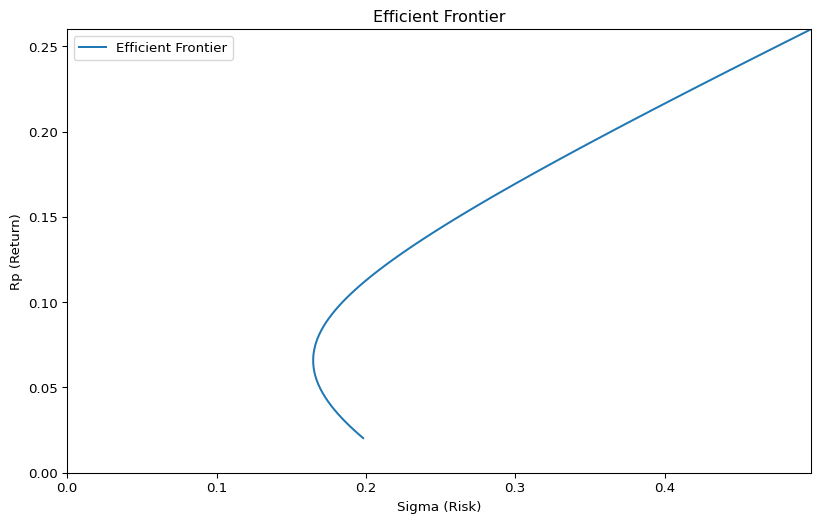

In [7]:
from matplotlib import pyplot as plt
#Creating plot
fig, ax = plt.subplots(figsize=(10, 6))
plot_scale = 52
MAX_AXIS = 0.005
#applying the function
rp_values = np.linspace(0, MAX_AXIS-rf, 100)
sigma_values = portfolio_front(rp_values, A, B, C)

#plotting, after annualizing the weekly data
ax.plot(plot_scale**0.5*(sigma_values), plot_scale*(rp_values+rf), 
                        label='Efficient Frontier')

#plot settings:
ax.set_xlim([0, np.max(sigma_values*plot_scale**0.5)])
ax.set_ylim([0, (np.max(rp_values)+rf)*plot_scale])
ax.set_xlabel('Sigma (Risk)')
ax.set_ylabel('Rp (Return)')
ax.set_title('Efficient Frontier')
ax.legend()

Legger til punkte for den optimale porteføljen:

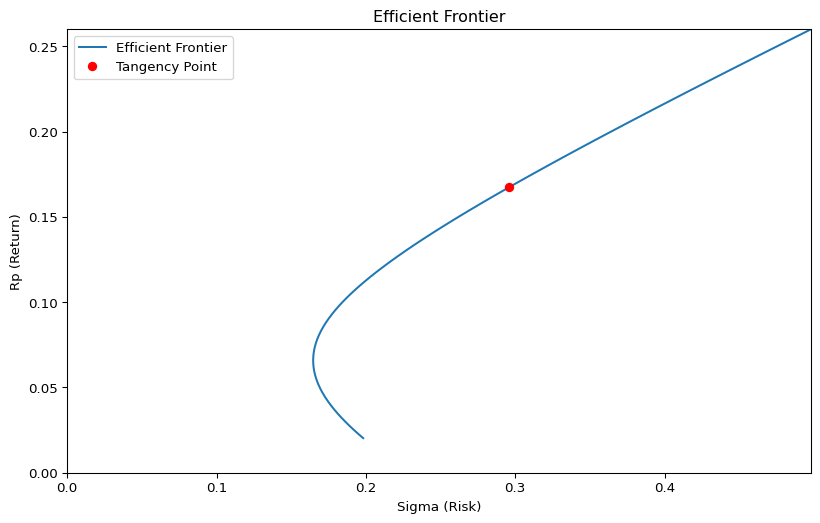

In [8]:
# Calculating the tangency point of the normalized 
# optimal portfolio
tangency_sigma =  portfolio_front(C/B, A, B, C)

#plotting it, after annualizing the weekly data
ax.plot(plot_scale**0.5*tangency_sigma, 
                    plot_scale*(C/B + rf), 
                    'ro',label='Tangency Point')
ax.legend()
fig

## Porteføljefronten med optimal portefølje og tangeringslinje

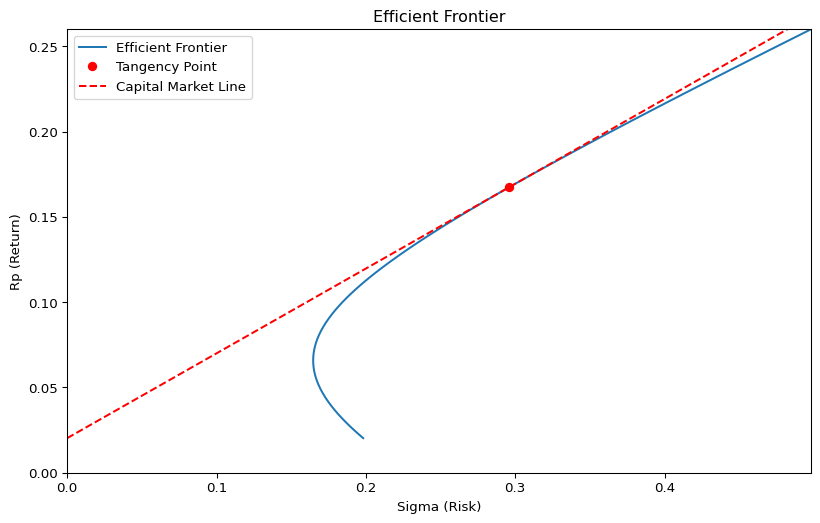

In [9]:
sigma_range = np.linspace(0, np.max(sigma_values), 100)

# Plotting the portfolio front, after annualizing the 
# weekly data
ax.plot(plot_scale**0.5*sigma_range, plot_scale*(rf 
                + sigma_range*(C/B)/tangency_sigma), 
                color='r', linestyle='--', 
                label='Capital Market Line')

ax.legend()

fig

# Forelesning 4: Faktorer

Finner volatilitet og avkastning til faktorene:

In [10]:
import pandas as pd

df = pd.read_pickle('output/factors.df')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df_weekly = df.resample('W').sum()
df_weekly = df_weekly[['SMB', 'HML', 'LIQ', 'MOM']].dropna()
df = df[['SMB', 'HML', 'LIQ', 'MOM']].dropna()
means = df_weekly.mean()*52
std = df_weekly.std()*52**0.5
print(std)
print(means)
df_weekly

SMB    0.145195
HML    0.193652
LIQ    0.160615
MOM    0.216708
dtype: float64
SMB    0.074676
HML    0.145056
LIQ    0.019353
MOM    0.164041
dtype: float64

431 rows × 4 columns

Plotter punktene i grafen fra forrige kapittel:

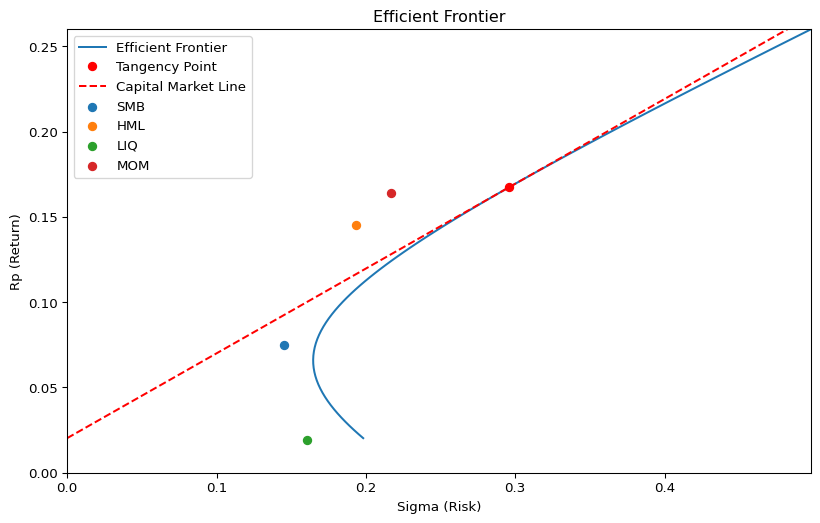

In [11]:
for series in means.index:
        ax.scatter(std[series], means[series], label=series)

ax.legend()

fig

# Forelesning 5: VaR

#### Utregninger

In [12]:
import numpy as np
def generate_backtest(f, df, name, estimation_win_size):
    # Initialize lists to store calculated values
    datelist = []
    sigmalist = []
    d95list = []
    d99list = []
    ret = []

    # Iterate over returns to calculate and store VaR and volatility estimates
    for t in range(estimation_win_size, len(df)):
        
        # Record date and current return
        datelist.append(df.index[t].date())
        ret.append(df[name].iloc[t])

        # Extract data from the estimation window (t-estimation_win_size to t-1)
        x = df[name].iloc[t-estimation_win_size:t-1]

        # Apply the provided VaR estimation function using the historical data and past volatility
        d95, d99, sigma = f(x, sigmalist)

        # Append the estimates to their respective lists
        sigmalist.append(sigma)
        d95list.append(d95)
        d99list.append(d99)

    # Return the results as numpy arrays for ease of analysis
    return (np.array(d95list),
            np.array(d99list),
            np.array(sigmalist),
            np.array(datelist),
            np.array(ret))

In [13]:
import matplotlib.pyplot as plt
def evaluate(plt, d95, d99, ret, dates, heading):
    # Clear the plot area to avoid overlapping plots
    plt.cla()

    # Plot the 95% VaR, 99% VaR, and actual returns
    plt.plot(dates, d95, label='95% Confidence Level')
    plt.plot(dates, d99, label='99% Confidence Level')
    plt.plot(dates, ret, label='Actual Return')

    # Highlight instances where returns breach the 95% VaR
    maxret = max(ret)
    breaches_95 = [maxret if d > r else 0 for d, r in zip(d95, ret)]
    plt.bar(dates, breaches_95, color='gray', alpha=0.5, width=0.5, label='Breaches 95% VaR')

    # Set labels and title
    plt.ylabel('VaR')
    plt.xlabel('Date')
    plt.title(heading)
    plt.xticks(rotation=90)
    plt.legend(loc="lower right")
    plt.subplots_adjust(bottom=0.15)
    plt.show()

    # Calculate and print the breach percentage for each confidence level
    backtest_results = [np.round(sum(d > ret) / len(ret) * 100, 1) for d in [d95, d99]]

    for i, level in enumerate([95, 99]):
        breaches = sum([d95, d99][i] > ret)
        print(f"{heading} with {level}% confidence interval:\n"
              f"Breaches: {breaches}\n"
              f"Backtesting (Realized VaR - % breaches): {backtest_results[i]}%\n")

In [14]:
PVALS = [0.05, 0.01]  # Confidence intervals (95% and 99%)
from scipy.stats import norm

def normal_est(x, sigmalist):
    z = norm.ppf(PVALS)  # Z-scores for the specified confidence levels
    sigma = np.std(x, ddof=1)  # Sample standard deviation
    return z[0] * sigma, z[1] * sigma, sigma

def historical_est(x, sigmalist):
    q95 = abs(np.quantile(x, PVALS[0]))  # 95th percentile of historical losses
    q99 = abs(np.quantile(x, PVALS[1]))  # 99th percentile of historical losses
    return -q95, -q99, None  # VaR values are negative to indicate potential loss

def last_volat(x, sigmalist):
    x = np.array(x)
    z = norm.ppf(PVALS)
    if not sigmalist:  # If sigmalist is empty, use initial standard deviation
        sigma = np.std(x, ddof=1)
    else:  # Update sigma based on past volatility and recent error
        sigma = (0.1 * (x[0] - np.mean(x))**2 + 0.9 * sigmalist[-1]**2)**0.5
    return z[0] * sigma, z[1] * sigma, sigma

#### Evaluering

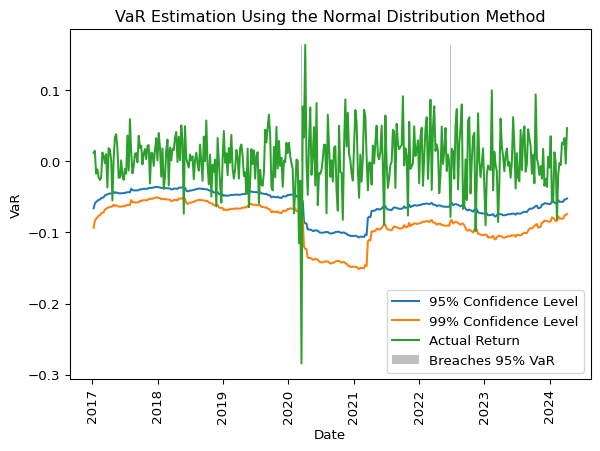

VaR Estimation Using the Normal Distribution Method with 95% confidence interval:
Breaches: 21
Backtesting (Realized VaR - % breaches): 5.5%

VaR Estimation Using the Normal Distribution Method with 99% confidence interval:
Breaches: 8
Backtesting (Realized VaR - % breaches): 2.1%


In [15]:
NAME = 'EQNR'
ESTIMATION_WINSIZE = 52

df = pd.read_pickle('output/X.df')


(normal95, normal99, 
 sigma, dates, ret )= generate_backtest(normal_est, 
        df, NAME, ESTIMATION_WINSIZE)
evaluate(plt, normal95, normal99, ret, dates,
         'VaR Estimation Using the Normal Distribution Method')